In [5]:
#! /usr/bin/env python

# PonyGE2
# Copyright (c) 2017 Michael Fenton, James McDermott,
#                    David Fagan, Stefan Forstenlechner,
#                    and Erik Hemberg
# Hereby licensed under the GNU GPL v3.
""" Python GE implementation """

from utilities.algorithm.general import check_python_version

check_python_version()
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from stats.stats import get_stats
from algorithm.parameters import params, set_params
import sys
import time
import numpy as np
np.set_printoptions(linewidth=150)
import random
import os
import pickle

from utilities.stats import trackers


In [13]:
file_path = f"./results_data/results_data_fold_1.pkl"

# Load the data
with open(file_path, 'rb') as f:
    loaded_data = pickle.load(f)

# Access the loaded data
crossover_rates = loaded_data['crossover_rates']
seeds = loaded_data['seeds']
test_results = loaded_data['test_results']
train_results = loaded_data['train_results']
test_evolution = loaded_data['test_evolution']
train_evolution = loaded_data['train_evolution']

#print(test_results[1][2])

print("Crossover rates:", crossover_rates)
print("Seeds:", seeds)
print("Test results shape:", test_results.shape)
print("Train results shape:", train_results.shape)
print("Test evolution shape:", test_evolution.shape)
print("Train evolution shape:", train_evolution.shape)


Crossover rates: [0.         0.16666667 0.33333333 0.5       ]
Seeds: [382848859 372844088  75509776]
Test results shape: (3, 4)
Train results shape: (3, 4)
Test evolution shape: (3, 4, 51)
Train evolution shape: (3, 4, 51)


In [12]:
print(train_results)

[[73.38129496 76.25899281 75.53956835 71.22302158]
 [77.69784173 72.6618705  75.53956835 74.82014388]
 [76.97841727 74.10071942 74.82014388 76.97841727]]


In [14]:
print(test_results)

[[77.14285714 71.42857143 71.42857143 77.14285714]
 [82.85714286 91.42857143 74.28571429 68.57142857]
 [68.57142857 77.14285714 77.14285714 71.42857143]]


[[71.42857143 74.28571429 74.28571429 71.42857143 91.42857143 85.71428571 74.28571429 65.71428571]
 [74.28571429 82.85714286 77.14285714 94.28571429 68.57142857 65.71428571 82.85714286 77.14285714]
 [74.28571429 77.14285714 77.14285714 71.42857143 91.42857143 68.57142857 85.71428571 57.14285714]
 [74.28571429 80.         82.85714286 65.71428571 71.42857143 82.85714286 74.28571429 74.28571429]
 [68.57142857 68.57142857 65.71428571 60.         65.71428571 82.85714286 74.28571429 88.57142857]]


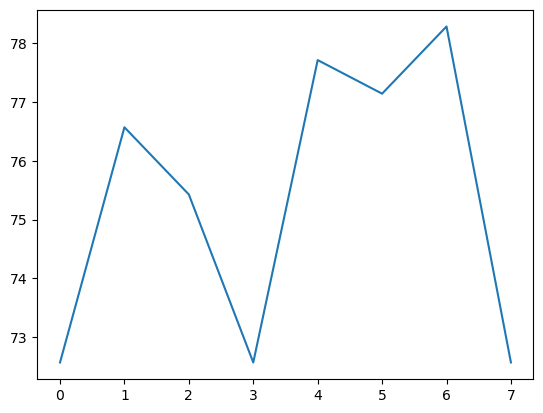

In [10]:
print(test_results)

#for i in range(5):

data = np.mean(test_results, axis=0)

plt.plot(data)
plt.show()